In [ ]:
from IPython.display import clear_output

In [ ]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    #transforms.Resize((32,32)) #important in the image data that have different sizes
])
#split the data
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

100%|██████████| 169M/169M [01:02<00:00, 2.69MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(f'{len(train_dataset)=}')
print(f'{len(test_dataset)=}')

len(train_dataset)=50000
len(test_dataset)=10000


In [ ]:
img, label = test_dataset[10] #check the image number 10 , you can check anyone in order to check that the sizes are the same
print(f'{label=}')
transforms.functional.to_pil_image(img) #tensor to PIL then print the PIL, this is how print the shape
img.shape

label=71


torch.Size([3, 32, 32])

# Tasks

1. Train a custom CNN classifier for CIFAR100 dataset.
2. Draw a graph to show the drop in losses (train loss and val loss) during the training.
2. After training on train data, do validation on test_data and show the overall accuracy of the model.
3. Also show label wise performance/accuracy of the model.

In [ ]:

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1) #32
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1) #16
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1) #8
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(0.5) #not neccessarily
        self.fc1 = nn.Linear(256 * 4 * 4, 512) #4 #we use FC layer not as Lab2 because there we didn't want to generate a new image (out_channel*input_size , )
        self.fc2 = nn.Linear(512, 100) #100 from CIFAR100, it 100 classes out

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2) #this is reduce the sie after each Conv
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = nn.Flatten()(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x, None, None #so we can pass it in loss

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10, Train Loss: 3.6789, Val Loss: 3.2733
Epoch 2/10, Train Loss: 3.0679, Val Loss: 2.8988
Epoch 3/10, Train Loss: 2.7674, Val Loss: 2.6636
Epoch 4/10, Train Loss: 2.5494, Val Loss: 2.4136
Epoch 5/10, Train Loss: 2.3964, Val Loss: 2.3665
Epoch 6/10, Train Loss: 2.2699, Val Loss: 2.2410
Epoch 7/10, Train Loss: 2.1624, Val Loss: 2.1804
Epoch 8/10, Train Loss: 2.0776, Val Loss: 2.0352
Epoch 9/10, Train Loss: 2.0129, Val Loss: 2.0478
Epoch 10/10, Train Loss: 1.9408, Val Loss: 1.9699


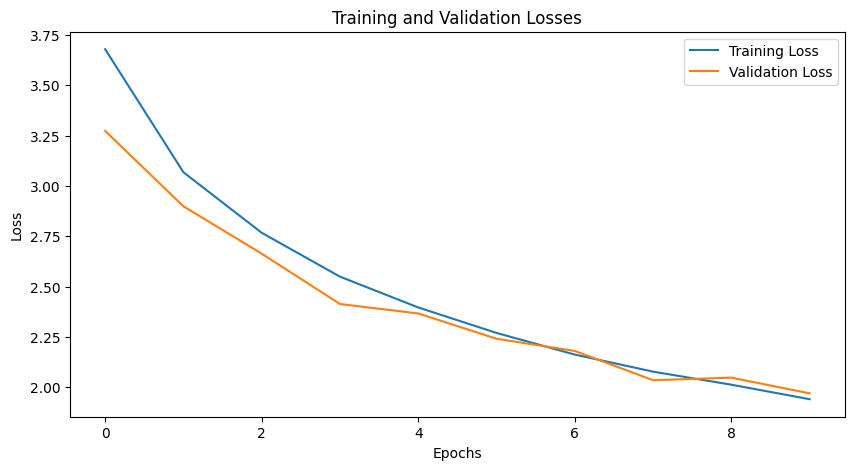

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F

num_epochs = 10
net = ImprovedCNN().to(device)

# Data to GPU
lr = 0.01 # Learning rate for the SGD optimizer.
momentum = 0.9
train_losses = []
val_losses = []
opt = optim.SGD(net.parameters(), lr = lr, momentum = momentum,weight_decay=5e-4)
sch = ExponentialLR(opt, 0.9, verbose = True)

for epoch in range(num_epochs):
    net.train()
    total_train_loss = 0

    for batch in train_loader:
        X, y = batch[0].to(device), batch[1].to(device)
        yhat = net(X)[0]
        loss = F.cross_entropy(yhat, y) # if we dont write this line before return x, None, None, we will got mismatch
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    net.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            yhat_val = net(X_val)[0]
            val_loss = F.cross_entropy(yhat_val, y_val)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    sch.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for batch in test_loader:
        X_test, y_test = batch[0].to(device), batch[1].to(device)
        yhat_test = net(X_test)[0]
        _, predicted_labels = torch.max(yhat_test, 1)
        correct_predictions += (predicted_labels == y_test).sum().item()
        total_samples += y_test.size(0)

# Calculate the accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy on the test set: {100 * accuracy:.2f}%")

Accuracy on the test set: 46.94%


In [ ]:
from sklearn.metrics import classification_report

true_labels = []
predictions =[]
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)[0]
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

tt=(classification_report(true_labels, predictions, target_names=train_dataset.classes))
print(tt)

               precision    recall  f1-score   support

        apple       0.77      0.72      0.75       100
aquarium_fish       0.71      0.37      0.49       100
         baby       0.39      0.32      0.35       100
         bear       0.24      0.27      0.25       100
       beaver       0.23      0.34      0.28       100
          bed       0.42      0.48      0.45       100
          bee       0.52      0.59      0.55       100
       beetle       0.43      0.47      0.45       100
      bicycle       0.70      0.50      0.58       100
       bottle       0.70      0.56      0.62       100
         bowl       0.39      0.24      0.30       100
          boy       0.38      0.25      0.30       100
       bridge       0.68      0.30      0.42       100
          bus       0.45      0.26      0.33       100
    butterfly       0.41      0.40      0.40       100
        camel       0.44      0.20      0.28       100
          can       0.50      0.45      0.47       100
       ca

In [ ]:
print(tt)

               precision    recall  f1-score   support

        apple       0.77      0.72      0.75       100
aquarium_fish       0.71      0.37      0.49       100
         baby       0.39      0.32      0.35       100
         bear       0.24      0.27      0.25       100
       beaver       0.23      0.34      0.28       100
          bed       0.42      0.48      0.45       100
          bee       0.52      0.59      0.55       100
       beetle       0.43      0.47      0.45       100
      bicycle       0.70      0.50      0.58       100
       bottle       0.70      0.56      0.62       100
         bowl       0.39      0.24      0.30       100
          boy       0.38      0.25      0.30       100
       bridge       0.68      0.30      0.42       100
          bus       0.45      0.26      0.33       100
    butterfly       0.41      0.40      0.40       100
        camel       0.44      0.20      0.28       100
          can       0.50      0.45      0.47       100
       ca